<a href="https://colab.research.google.com/github/makowskiignacy/PELN/blob/main/Drzewa_martwe_drewna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


In [117]:
# === KROK 1: Przygotowanie danych ===
# W realnym scenariuszu wczytałbyś dane z pliku CSV, np.:
dane1 = pd.read_csv('PELN - Van Wagner NS (martwe drewno) (2).csv')
dane2 = pd.read_csv('PELN - Van Wagner WZ (martwe drewno) (1).csv')

# Standaryzacja nazw kolumn i konwersja na angielski dla spójności
dane1.columns = ['Nr linii', 'Nr kwadratu', 'Gatunek', 'Srednica w przecieciu']
dane2.columns = ['Nr linii', 'Gatunek', 'Srednica w przecieciu', 'Nr kwadratu']
dane1['Pomiar'] = np.zeros(len(dane1))
dane2['Pomiar'] = np.ones(len(dane2))

# Uporządkowanie kolumn w dane2, aby pasowały do dane1
dane2 = dane2[['Nr linii', 'Nr kwadratu', 'Gatunek', 'Srednica w przecieciu', 'Pomiar']]

# Konwersja kolumny 'Srednica w przecieciu' na typ numeryczny,
# uwzględniając możliwe przecinki jako separatory dziesiętne i błędy
dane1['Srednica w przecieciu'] = dane1['Srednica w przecieciu'].astype(str).str.replace(',', '.', regex=False)
dane2['Srednica w przecieciu'] = dane2['Srednica w przecieciu'].astype(str).str.replace(',', '.', regex=False)
dane1['Srednica w przecieciu'] = pd.to_numeric(dane1['Srednica w przecieciu'], errors='coerce')
dane2['Srednica w przecieciu'] = pd.to_numeric(dane2['Srednica w przecieciu'], errors='coerce')


# Połączenie danych przy użyciu concat (dodanie wierszy jednego do drugiego)
dane = pd.concat([dane1, dane2], ignore_index=True)

# Zmiana nazw kolumn na mniejsze litery i angielskie nazwy
dane.columns = ['nr_linii', 'nr_kwadratu', 'gatunek', 'srednica_cm', 'pomiar']

# Usunięcie wierszy z brakującymi wartościami, które mogły powstać po konwersji numerycznej
dane.dropna(inplace=True)

# Upewnienie się, że kolumny liczbowe są odpowiedniego typu
dane['nr_linii'] = dane['nr_linii'].astype(int)
dane['nr_kwadratu'] = dane['nr_kwadratu'].astype(int)
dane['srednica_cm'] = dane['srednica_cm'].astype(float)

print(dane['nr_linii'].max())
print(dane1['Nr linii'].max())
print(dane2['Nr linii'].max())

6
5
6


In [118]:
dane_test.head()

,nr_linii,nr_kwadratu,gatunek,srednica_cm,dlugosc,objetosc
0,1,1,sw,22.5,19.70,443.25
1,1,1,db,13.0,6.70,87.10
2,1,2,sw,15.0,1.18,17.70
3,1,2,sw,11.5,2.00,23.00
4,1,3,os,7.0,2.00,14.00


In [119]:
dane_test = pd.read_csv('PELN - Van Wagner całkowity pomiar (martwe drewno) (1).csv')
dane_test.columns = ['nr_linii', 'nr_kwadratu', 'gatunek', 'srednica_cm', 'dlugosc']
dane_test['dlugosc'] = dane_test['dlugosc'].astype(str).str.replace(',', '.', regex=False)
dane_test['srednica_cm'] = dane_test['srednica_cm'].astype(str).str.replace(',', '.', regex=False)
dane_test['dlugosc'] = pd.to_numeric(dane_test['dlugosc'], errors='coerce')
dane_test['srednica_cm'] = pd.to_numeric(dane_test['srednica_cm'], errors='coerce')
dane_test['objetosc'] = dane_test['dlugosc'] * dane_test['srednica_cm']
dane_test.head()

,nr_linii,nr_kwadratu,gatunek,srednica_cm,dlugosc,objetosc
0,1,1,sw,22.5,19.70,443.25
1,1,1,db,13.0,6.70,87.10
2,1,2,sw,15.0,1.18,17.70
3,1,2,sw,11.5,2.00,23.00
4,1,3,os,7.0,2.00,14.00


In [143]:
ns_data = dane[dane['pomiar'] == 0]
wz_data = dane[dane['pomiar'] == 1]

# Process NS and WZ data for each square
def podziel_na_kwadraty(data_ns, data_wz, rozmiar_kwadratu=3):
    wyniki = []
    max_x = max(data_ns['nr_linii'].max(), data_wz['nr_linii'].max())
    max_y = max(data_ns['nr_kwadratu'].max(), data_wz['nr_kwadratu'].max())

    kwadrat_id = 1
    print(max_x - rozmiar_kwadratu + 1)
    print(max_y - rozmiar_kwadratu + 1)
    for start_x in range(1, max_x - rozmiar_kwadratu + 1):
        for start_y in range(1, max_y - rozmiar_kwadratu + 1):
            kwadrat_dict = {
                "kwadrat_id": kwadrat_id,
                "start_wspolrzedne": (start_x, start_y),
                "NS1": [], "NS2": [], "NS3": [], "NS4": [],
                "WZ1": [], "WZ2": [], "WZ3": [], "WZ4": []
            }

            # Collect NS data
            for i in range(rozmiar_kwadratu):
                wspolrzedne_ns = [(start_x + i, start_y), (start_x + i, start_y + 1), (start_x + i, start_y + 2)]
                ns_key = f"NS{i+1}"
                for wsp in wspolrzedne_ns:
                    obserwacje = data_ns[(data_ns['nr_linii'] == wsp[0]) & (data_ns['nr_kwadratu'] == wsp[1])]
                    if not obserwacje.empty:
                        kwadrat_dict[ns_key].extend(obserwacje[['gatunek', 'srednica_cm']].values.tolist())

            # Collect WZ data
            for i in range(rozmiar_kwadratu):
                wspolrzedne_wz = [(start_x, start_y + i), (start_x + 1, start_y + i), (start_x + 2, start_y + i)]
                wz_key = f"WZ{i+1}"
                for wsp in wspolrzedne_wz:
                    obserwacje = data_wz[(data_wz['nr_linii'] == wsp[0]) & (data_wz['nr_kwadratu'] == wsp[1])]
                    if not obserwacje.empty:
                        kwadrat_dict[wz_key].extend(obserwacje[['gatunek', 'srednica_cm']].values.tolist())

            wyniki.append(kwadrat_dict)
            kwadrat_id += 1

    return wyniki

# Generate results
wyniki_kwadratow = podziel_na_kwadraty(ns_data, wz_data)

# Display results
for wynik in wyniki_kwadratow:
    print(f"Kwadrat: {wynik['start_wspolrzedne']}")
    print(f"NS1: {wynik['NS1']}, NS2: {wynik['NS2']}, NS3: {wynik['NS3']}, NS4: {wynik['NS4']}")
    print(f"WZ1: {wynik['WZ1']}, WZ2: {wynik['WZ2']}, WZ3: {wynik['WZ3']}, WZ4: {wynik['WZ4']}")
    print()

4
9
Kwadrat: (1, 1)
NS1: [['gb', 14.0], ['sw', 29.0], ['db', 18.0], ['sw', 13.0]], NS2: [], NS3: [['sw', 23.0], ['sw', 37.0]], NS4: []
WZ1: [['sw ', 11.0], ['br', 21.0], ['br', 29.0], ['os', 18.0], ['sw ', 20.0]], WZ2: [['sw ', 33.0]], WZ3: [['sw ', 13.5], ['db', 17.0]], WZ4: []

Kwadrat: (1, 2)
NS1: [['db', 18.0], ['sw', 13.0]], NS2: [['sw', 22.0]], NS3: [['sw', 37.0], ['db', 16.0]], NS4: []
WZ1: [['sw ', 33.0]], WZ2: [['sw ', 13.5], ['db', 17.0]], WZ3: [['sw ', 20.0], ['db', 14.0]], WZ4: []

Kwadrat: (1, 3)
NS1: [], NS2: [['sw', 22.0], ['db', 17.0]], NS3: [['db', 16.0]], NS4: []
WZ1: [['sw ', 13.5], ['db', 17.0]], WZ2: [['sw ', 20.0], ['db', 14.0]], WZ3: [['br', 11.5]], WZ4: []

Kwadrat: (1, 4)
NS1: [], NS2: [['sw', 22.0], ['db', 17.0]], NS3: [['db', 16.0]], NS4: []
WZ1: [['sw ', 20.0], ['db', 14.0]], WZ2: [['br', 11.5]], WZ3: [], WZ4: []

Kwadrat: (1, 5)
NS1: [], NS2: [['db', 17.0], ['db', 10.0]], NS3: [], NS4: []
WZ1: [['br', 11.5]], WZ2: [], WZ3: [['sw ', 15.0]], WZ4: []

Kwadrat:

In [121]:
# Funkcja do podziału siatki na kwadraty 3x3
def podziel_na_kwadraty(data, rozmiar_kwadratu=3):
    wyniki = {"Kwadrat": [], "objetosc": []}
    max_x = data['nr_linii'].max()
    print(max_x)
    max_y = data['nr_kwadratu'].max()
    print(max_y)

    for start_x in range(1, max_x - rozmiar_kwadratu + 2):
        for start_y in range(1, max_y - rozmiar_kwadratu + 2):
            # Filtruj dane dla aktualnego kwadratu
            kwadrat = data[
                (data['nr_linii'] >= start_x) & (data['nr_linii'] < start_x + rozmiar_kwadratu) &
                (data['nr_kwadratu'] >= start_y) & (data['nr_kwadratu'] < start_y + rozmiar_kwadratu)
            ]
            # Dodaj gatunki i średnice do wyników
            wyniki["Kwadrat"].append(f"({start_x}, {start_y})")
            # Calculate and append the sum of 'objetosc' for the current square
            wyniki["objetosc"].append(kwadrat['objetosc'].sum())

    # Create a list of dictionaries for easier printing
    wyniki_list = []
    for i in range(len(wyniki["Kwadrat"])):
        wyniki_list.append({
            "Kwadrat": wyniki["Kwadrat"][i],
            "objetosc": wyniki["objetosc"][i]
        })

    return wyniki_list


# Wywołanie funkcji
wyniki = podziel_na_kwadraty(dane_test)

# Wyświetlenie wyników
for wynik in wyniki:
    print(f"Kwadrat: {wynik['Kwadrat']}, Objętość: {wynik['objetosc']}")

5
10
Kwadrat: (1, 1), Objętość: 3577.85
Kwadrat: (1, 2), Objętość: 2660.35
Kwadrat: (1, 3), Objętość: 1891.27
Kwadrat: (1, 4), Objętość: 710.92
Kwadrat: (1, 5), Objętość: 2715.87
Kwadrat: (1, 6), Objętość: 3549.45
Kwadrat: (1, 7), Objętość: 5858.15
Kwadrat: (1, 8), Objętość: 4429.75
Kwadrat: (2, 1), Objętość: 2886.3999999999996
Kwadrat: (2, 2), Objętość: 2439.8
Kwadrat: (2, 3), Objętość: 1740.8
Kwadrat: (2, 4), Objętość: 727.05
Kwadrat: (2, 5), Objętość: 3150.45
Kwadrat: (2, 6), Objętość: 4268.249999999999
Kwadrat: (2, 7), Objętość: 5619.15
Kwadrat: (2, 8), Objętość: 3831.7499999999995
Kwadrat: (3, 1), Objętość: 2219.7
Kwadrat: (3, 2), Objętość: 1240.4
Kwadrat: (3, 3), Objętość: 2434.4
Kwadrat: (3, 4), Objętość: 1537.7
Kwadrat: (3, 5), Objętość: 3860.7
Kwadrat: (3, 6), Objętość: 3705.7
Kwadrat: (3, 7), Objętość: 5047.3
Kwadrat: (3, 8), Objętość: 3510.9


In [144]:
def generuj_wiersze(wyniki_kwadratow):
    wiersze = []

    for kwadrat in wyniki_kwadratow:
        start_wspolrzedne = kwadrat['start_wspolrzedne']

        # Extract NS and WZ keys
        NS_keys = ['NS1', 'NS2', 'NS3', 'NS4']
        WZ_keys = ['WZ1', 'WZ2', 'WZ3', 'WZ4']

        # Generate rows for each NS-WZ combination
        for ns_key in NS_keys:
            ns_value = kwadrat.get(ns_key, [])
            for wz_key in WZ_keys:
                wz_value = kwadrat.get(wz_key, [])

                # Combine NS and WZ values into a single row
                wiersze.append({
                    'Kwadrat': start_wspolrzedne,
                    'NS_WZ': f"{ns_key}{wz_key}",
                    'obserwacje': [*ns_value, *wz_value]
                })

    return wiersze


kombinacje = stworz_kombinacje(wyniki_kwadratow)

# Display results
for k in kombinacje:
    print(k)

NameError: name 'wz_obs' is not defined

In [145]:
df = pd.DataFrame(wiersze)
df['Kwadrat'] = df['Kwadrat'].astype(str)
df.head()

,Kwadrat,NS_WZ,NS
0,"(1, 1)",NS1WZ1,"[[gb, 14.0], [sw, 29.0], [db, 18.0], [sw, 13.0..."
1,"(1, 1)",NS1WZ2,"[[gb, 14.0], [sw, 29.0], [db, 18.0], [sw, 13.0..."
2,"(1, 1)",NS1WZ3,"[[gb, 14.0], [sw, 29.0], [db, 18.0], [sw, 13.0..."
3,"(1, 1)",NS1WZ4,"[[gb, 14.0], [sw, 29.0], [db, 18.0], [sw, 13.0]]"
4,"(1, 1)",NS2WZ1,"[[sw , 11.0], [br, 21.0], [br, 29.0], [os, 18...."


In [146]:
obj = pd.DataFrame(wyniki)
type(obj.iloc[0][0])

/tmp/ipython-input-146-2144753668.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  type(obj.iloc[0][0])


str

In [149]:
# Łączenie tabel na podstawie kolumny 'Kwadrat'
polaczona_tabela = pd.merge(df, obj, on='Kwadrat', how='left').drop(columns=['Kwadrat', 'NS_WZ'])
polaczona_tabela.columns = ['obserwacje', 'objetosc']

# Wyświetlenie wyników
print(polaczona_tabela)

                                            obserwacje  objetosc
0    [[gb, 14.0], [sw, 29.0], [db, 18.0], [sw, 13.0...   3577.85
1    [[gb, 14.0], [sw, 29.0], [db, 18.0], [sw, 13.0...   3577.85
2    [[gb, 14.0], [sw, 29.0], [db, 18.0], [sw, 13.0...   3577.85
3     [[gb, 14.0], [sw, 29.0], [db, 18.0], [sw, 13.0]]   3577.85
4    [[sw , 11.0], [br, 21.0], [br, 29.0], [os, 18....   3577.85
..                                                 ...       ...
379                                       [[sw, 16.0]]   3510.90
380  [[sw , 15.0], [db, 65.0], [db, 50.0], [sw , 34...   3510.90
381  [[sw , 31.0], [br, 20.0], [sw , 11.0], [db, 41...   3510.90
382  [[db, 11.0], [db, 24.0], [sw , 18.0], [db, 63....   3510.90
383                                                 []   3510.90

[384 rows x 2 columns]


In [170]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


# Przykładowe dane
data = polaczona_tabela

# Preprocessing data
def preprocess_data(data):
    # Separate strings and floats from observation lists
    texts = [' '.join([item[0] for item in obs]) for obs in data['obserwacje']]
    floats = [np.mean([item[1] for item in obs]) for obs in data['obserwacje']]

    # OneHotEncoding for strings
    encoder = OneHotEncoder(sparse_output=False)
    text_features = encoder.fit_transform(np.array(texts).reshape(-1, 1))

    # Combine text features and numerical features
    features = np.hstack([text_features, np.array(floats).reshape(-1, 1)])
    return features, encoder

# Process data
X, encoder = preprocess_data(data)
y = data['objetosc']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define model and hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV for hyperparameter tuning
model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


Mean Absolute Error (MAE): 823.7727634839524
Mean Squared Error (MSE): 1155765.043117558
R² Score: 0.3711501104148466


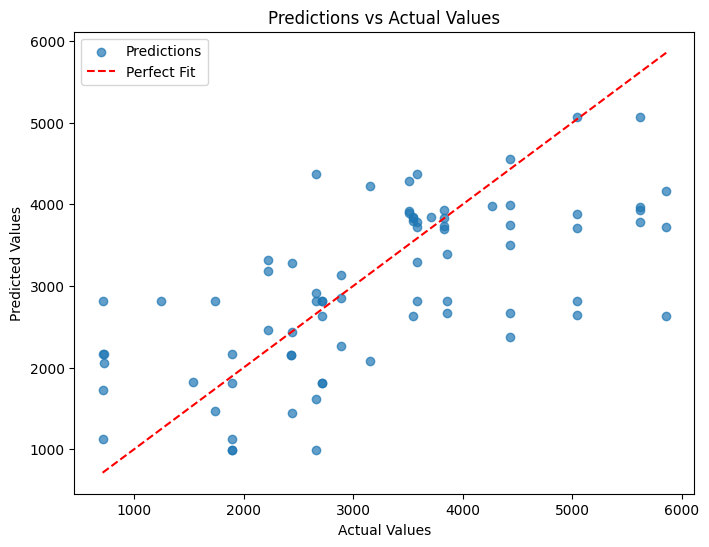

In [171]:

# Predictions on validation set
y_pred = best_model.predict(X_val)

# Calculate regression metrics
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

# Plot predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.7, label='Predictions')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual Values')
plt.legend()
plt.show()

Random Forest Performance:
Mean Absolute Error (MAE): 824.1584922176286
Mean Squared Error (MSE): 1161799.6511620472
R² Score: 0.367866689943649

XGBoost Performance:
Mean Absolute Error (MAE): 820.0793620637177
Mean Squared Error (MSE): 1224610.5309063718
R² Score: 0.3336913919216379


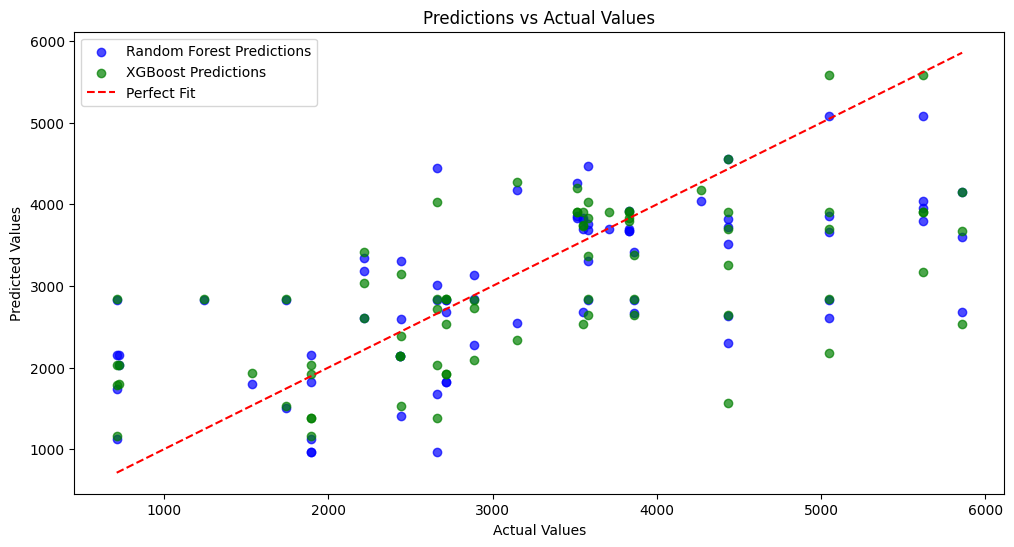

In [177]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt



# Preprocessing data
def preprocess_data(data):
    # Separate strings and floats from observation lists
    texts = [' '.join([item[0] for item in obs]) for obs in data['obserwacje']]
    floats = [np.mean([item[1] for item in obs]) for obs in data['obserwacje']]

    # OneHotEncoding for strings
    encoder = OneHotEncoder(sparse_output=False)
    text_features = encoder.fit_transform(np.array(texts).reshape(-1, 1))

    # Combine text features and numerical features
    features = np.hstack([text_features, np.array(floats).reshape(-1, 1)])
    return features, encoder

# Process data
X, encoder = preprocess_data(data)
y = data['objetosc']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)

# Train XGBoost model
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_val)

# Evaluate both models
rf_mae = mean_absolute_error(y_val, rf_pred)
rf_mse = mean_squared_error(y_val, rf_pred)
rf_r2 = r2_score(y_val, rf_pred)

xgb_mae = mean_absolute_error(y_val, xgb_pred)
xgb_mse = mean_squared_error(y_val, xgb_pred)
xgb_r2 = r2_score(y_val, xgb_pred)

print("Random Forest Performance:")
print(f"Mean Absolute Error (MAE): {rf_mae}")
print(f"Mean Squared Error (MSE): {rf_mse}")
print(f"R² Score: {rf_r2}")

print("\nXGBoost Performance:")
print(f"Mean Absolute Error (MAE): {xgb_mae}")
print(f"Mean Squared Error (MSE): {xgb_mse}")
print(f"R² Score: {xgb_r2}")

# Plot predictions vs actual values for both models
plt.figure(figsize=(12, 6))
plt.scatter(y_val, rf_pred, alpha=0.7, label='Random Forest Predictions', color='blue')
plt.scatter(y_val, xgb_pred, alpha=0.7, label='XGBoost Predictions', color='green')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual Values')
plt.legend()
plt.show()

In [ ]:
def fun_wagner(V,L,transect):
  fun = V
  return obj